In [1]:
import io
import itertools
import numbers
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASETS = {
    'ogbg-molhiv': 'MolHIV',
    'dgn-hiv': 'MolHIV',
    'ogbg-molpcba': 'MolPCBA',
    'dgn-pcba': 'MolPCBA',
    'molhiv': 'MolHIV',
    'molpcba': 'MolPCBA',
    'dgn-cora': 'Cora',
    'dgn-citeseer': 'CiteSeer',
    'dgn-pubmed': 'PubMed',
    'cora': 'Cora',
    'citeseer': 'CiteSeer',
    'pubmed': 'PubMed',
}

MODELS = {
    'gin': 'GIN',
    'gin-virtual-node': 'GIN+VN',
    'gcn': 'GCN',
    'gcn-virtual-node': 'GCN+VN',
    'gat': 'GAT',
    'pna': 'PNA',
    'dgn-hiv': 'DGN',
    'dgn-pcba': 'DGN',
    'dgn': 'DGN',
}

In [3]:
cpu_csv = pd.read_csv('cpu.csv')
cuda_csv = pd.read_csv('cuda.csv')

In [4]:
def read_opencl_summary(path, section='Kernel Execution'):
    with open(path) as f:
        f_iter = iter(f)
        try:
            while True:
                section_name = next(f_iter).rstrip('\n')
                section_lines = io.StringIO()
                for line in f_iter:
                    if not line.rstrip('\n'):
                        break
                    section_lines.write(line)
                section_lines.seek(0)
                if section_name == section:
                    return pd.read_csv(section_lines)
        except StopIteration:
            pass

In [5]:
gengnn_dfs = []
for entry in os.scandir('fpga'):
    if not entry.is_dir():
        continue
    dataset = DATASETS[entry.name]
    for subentry in os.scandir(entry.path):
        if not subentry.is_file():
            continue
        basename, ext = os.path.splitext(subentry.name)
        model = MODELS[basename]

        summary_csv = read_opencl_summary(subentry.path)
        summary_csv['Device'] = 'GenGNN'
        summary_csv['Dataset'] = dataset
        summary_csv['Model'] = model
        summary_csv['Latency'] = summary_csv['Average Time (ms)']
        gengnn_dfs.append(summary_csv)

In [6]:
df = pd.concat([cpu_csv, cuda_csv], keys=['CPU (PyG)', 'GPU (PyG)'], names=['Device'])
df.reset_index(level='Device', inplace=True)
df = df[df['Batch size'] == 1]
df['Dataset'] = df['Dataset name'].map(DATASETS)
df['Model'] = df['Model name'].map(MODELS)
df['Latency'] = df['Average run time per graph'] * 1e3
df = pd.concat([df, *gengnn_dfs])
df = df[['Device', 'Dataset', 'Model', 'Latency']]

molhiv = df[df['Dataset'] == 'MolHIV']
molpcba = df[df['Dataset'] == 'MolPCBA']

In [7]:
sns.set_theme(style='whitegrid')
sns.set_palette(['#9DC3E6', '#F4B183', '#A9D18E'])

In [8]:
def annotate(ax, offsets=50):
    cpu_bars, gpu_bars, gengnn_bars = ((container.patches, container.datavalues) for container in ax.containers)
    if isinstance(offsets, numbers.Real):
        offsets = itertools.repeat(offsets)
    for cpu_bar, gpu_bar, gengnn_bar, offset in zip(zip(*cpu_bars), zip(*gpu_bars), zip(*gengnn_bars), offsets):
        cpu_rect, cpu_val = cpu_bar
        gpu_rect, gpu_val = gpu_bar
        gengnn_rect, gengnn_val = gengnn_bar

        def speedup_text(from_val):
            if from_val > gengnn_val:
                speedup = from_val / gengnn_val
                direction = '↓'
            elif from_val < gengnn_val:
                speedup = gengnn_val / from_val
                direction = '↑'
            else:
                speedup = 1.0
                direction = ''
            return f'{speedup:.2f}x{direction}'

        xy = (gengnn_rect.get_x() + 0.5 * gengnn_rect.get_width(), gengnn_rect.get_y() + gengnn_rect.get_height())
        text = f'~CPU: {speedup_text(cpu_val)}\n~GPU: {speedup_text(gpu_val)}'
        if isinstance(offset, numbers.Real):
            offset = (0, offset)

        ax.annotate(
            text,
            xy=xy,
            xytext=offset,
            textcoords='offset points',
            ha='center',
            ma='left',
            fontsize='small',
            backgroundcolor=gengnn_rect.get_facecolor(),
            arrowprops={
                'arrowstyle': '->',
                'color': gengnn_rect.get_facecolor(),
                'shrinkB': 10,
                'lw': 1.5,
            },
        )

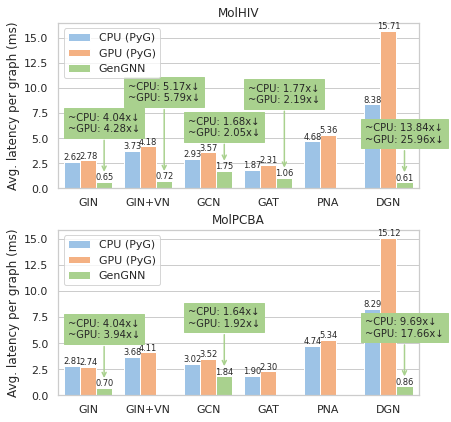

In [9]:
fig, (ax_molhiv, ax_molpcba) = plt.subplots(2, 1, figsize=(6, 6))
fig.tight_layout(pad=1.5)

sns.barplot(x='Model', y='Latency', hue='Device', ci=None, data=molhiv, ax=ax_molhiv, saturation=1)
ax_molhiv.set(xlabel=None, ylabel='Avg. latency per graph (ms)', title='MolHIV');
for container in ax_molhiv.containers: ax_molhiv.bar_label(container, fmt='%.2f', fontsize='x-small')
annotate(ax_molhiv, offsets=[50, 80, 35, 75, 50, 40])
ax_molhiv.legend(loc='upper left').set_title(None);

sns.barplot(x='Model', y='Latency', hue='Device', ci=None, data=molpcba, ax=ax_molpcba, saturation=1)
ax_molpcba.set(xlabel=None, ylabel='Avg. latency per graph (ms)', title='MolPCBA');
for container in ax_molpcba.containers: ax_molpcba.bar_label(container, fmt='%.2f', fontsize='x-small')
annotate(ax_molpcba)
ax_molpcba.legend(loc='upper left').set_title(None);

fig.savefig('results.pdf', bbox_inches='tight')

In [10]:
cpu_large_csv = pd.read_csv('cpu.large.csv')
cuda_large_csv = pd.read_csv('cuda.large.csv')

In [11]:
lg_gengnn_dfs = []
for entry in os.scandir('large'):
    if not entry.is_file():
        continue
    basename, ext = os.path.splitext(entry.name)
    dataset = DATASETS[basename]

    summary_csv = read_opencl_summary(entry.path)
    summary_csv['Device'] = 'GenGNN'
    summary_csv['Dataset'] = dataset
    summary_csv['Model'] = 'DGN'
    summary_csv['Latency'] = summary_csv['Average Time (ms)']
    lg_gengnn_dfs.append(summary_csv)

In [12]:
lg_df = pd.concat([cpu_large_csv, cuda_large_csv], keys=['CPU (PyG)', 'GPU (PyG)'], names=['Device'])
lg_df.reset_index(level='Device', inplace=True)
lg_df = lg_df[lg_df['Batch size'] == 1]
lg_df['Dataset'] = lg_df['Dataset name'].map(DATASETS)
lg_df['Model'] = lg_df['Model name'].map(MODELS)
lg_df['Latency'] = lg_df['Average run time per graph'] * 1e3
lg_df = pd.concat([lg_df, *lg_gengnn_dfs])
lg_df = lg_df[['Device', 'Dataset', 'Model', 'Latency']]

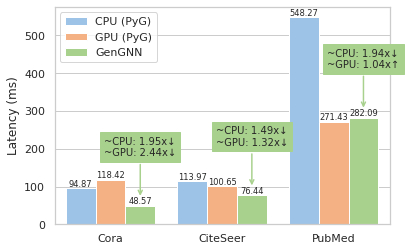

In [13]:
ax = sns.barplot(x='Dataset', y='Latency', hue='Device', ci=None, data=lg_df, saturation=1)
ax.set(xlabel=None, ylabel='Latency (ms)');
ax.legend().set_title(None);
for container in ax.containers: ax.bar_label(container, fmt='%.2f', fontsize='x-small')
annotate(ax)

ax.get_figure().savefig('results_large.pdf', bbox_inches='tight')